In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
# from sklearn.

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

### Removing Null values

In [4]:
train_data=train_data.dropna(how='any')

### Adding Date Columns

In [5]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

In [6]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour'],
      dtype='object')

### Dividing data into train and validation

In [7]:
X, y=train_data.drop('Rating', axis=1), train_data['Rating']
X_test=test_data

In [8]:
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=29)

### Pipeline

In [424]:
col_transform=ColumnTransformer([('scaler', MinMaxScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                #  ('day_encode', OneHotEncoder(), ['Day']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', CountVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])
weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', DecisionTreeClassifier(splitter='random', random_state=29, class_weight=weights,
                                                   max_depth=20, min_samples_split=8))])

In [414]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  CountVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x000002679E0E5990>)),
                ('clsf',
                 DecisionTreeClassifier(class_weight={0: 7, 1: 14, 2: 20, 3: 10,
                                                      4: 7, 5: 3},
                                        max_depth=20, min_samples_split=8,
                                        random_state=29, splitter='random'))])

### Train Report

In [415]:
train_predict=pipeline.predict(X_train)

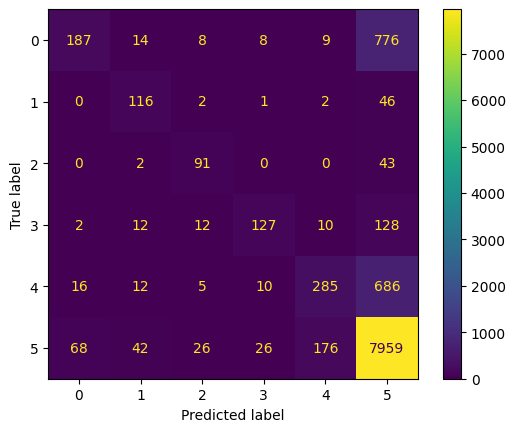

In [416]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=pipeline.classes_);

In [417]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.68      0.19      0.29      1002
           1       0.59      0.69      0.64       167
           2       0.63      0.67      0.65       136
           3       0.74      0.44      0.55       291
           4       0.59      0.28      0.38      1014
           5       0.83      0.96      0.89      8297

    accuracy                           0.80     10907
   macro avg       0.68      0.54      0.57     10907
weighted avg       0.78      0.80      0.77     10907



In [418]:
accuracy_score(y_train, train_predict)

0.8036123590354818

In [419]:
tree=pipeline.named_steps['clsf'].tree_
tree.node_count, tree.max_depth

(803, 20)

### Test Report

In [420]:
valid_predict=pipeline.predict(X_valid)

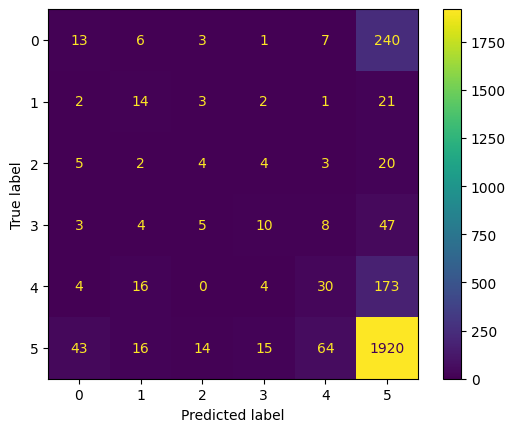

In [421]:
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);

In [422]:
print(classification_report(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.19      0.05      0.08       270
           1       0.24      0.33      0.28        43
           2       0.14      0.11      0.12        38
           3       0.28      0.13      0.18        77
           4       0.27      0.13      0.18       227
           5       0.79      0.93      0.85      2072

    accuracy                           0.73      2727
   macro avg       0.32      0.28      0.28      2727
weighted avg       0.66      0.73      0.68      2727



In [423]:
accuracy_score(y_valid, valid_predict)

0.7301063439677301

### Training on whole dataset

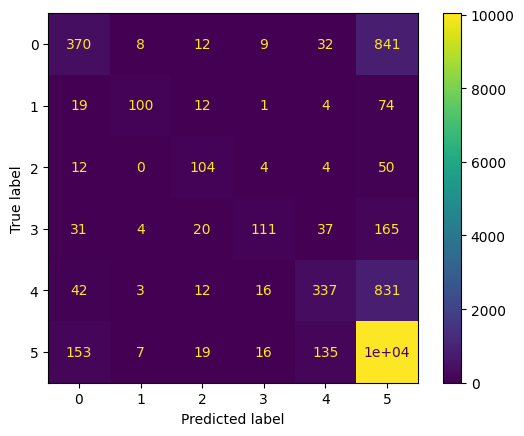

In [142]:
pipeline.fit(X, y)
whole_predict=pipeline.predict(X)
ConfusionMatrixDisplay.from_predictions(y, whole_predict, display_labels=pipeline.classes_);

In [143]:
print(classification_report(y, whole_predict))

              precision    recall  f1-score   support

           0       0.59      0.29      0.39      1272
           1       0.82      0.48      0.60       210
           2       0.58      0.60      0.59       174
           3       0.71      0.30      0.42       368
           4       0.61      0.27      0.38      1241
           5       0.84      0.97      0.90     10369

    accuracy                           0.81     13634
   macro avg       0.69      0.48      0.55     13634
weighted avg       0.79      0.81      0.78     13634



In [144]:
accuracy_score(y, whole_predict)

0.8112806219744756

In [338]:
test_predict=pipeline.predict(X_test)